# Анализ факторов, влияющих на продажи видеоигр для интернет-магазина «Стримчик»

Цель проекта — выявить закономерности, определяющие коммерческий успех видеоигр, чтобы использовать эти знания при планировании маркетинговых кампаний и формировании ассортимента.

Источник данных: открытые исторические данные о видеоиграх до 2016 года — платформы, жанры, оценки пользователей и критиков, возрастные рейтинги ESRB, а также данные о глобальных и региональных продажах.

Основные этапы:

- Предобработка данных и исследовательский анализ.

- Определение актуального периода анализа.

- Сегментация по платформам и жанрам.

- Оценка влияния оценок, жанров и рейтингов на продажи.

Проект демонстрирует навыки EDA, обработки категориальных признаков, выявления трендов и обоснования бизнес-решений на основе данных.

## Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# Загрузка данных
data = pd.read_csv('games.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


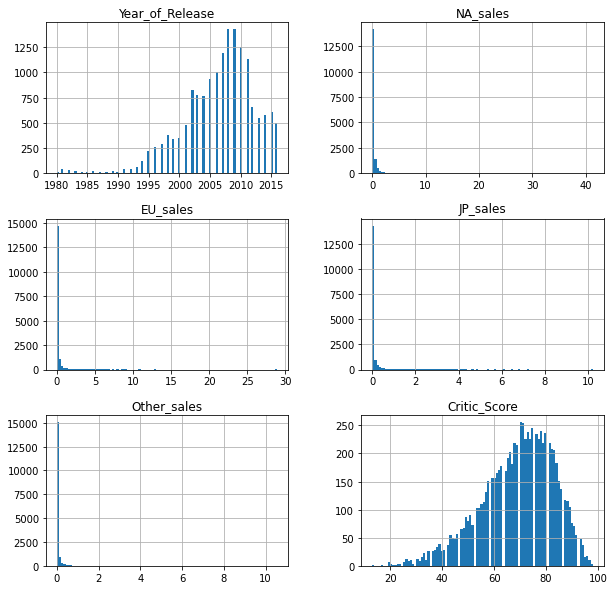

In [6]:
data.hist(bins=100, figsize=(10,10));

Присутствуют выбросы в столбцах NA_sales, EU_sales, JP_sales, Other_sales.  
Столбцы Year_of_Release, Critic_Score имеют распределение, скошенное слева.

## Подготовьте данные

### Замените названия столбцов (приведите к нижнему регистру);

In [7]:
data.rename(inplace=True, columns={'Name': 'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 
                                   'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales',
                                   'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score': 'critic_score',
                                   'User_Score': 'user_score', 'Rating': 'rating'})

In [8]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;

year_of_release нужно в int, так как год не может быть с дробной частью. Int64, потому что не будет ошибки с Nan

In [9]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


В будущем, после обработки пропусков, переведем столбец critic_score в int, так как там тоже нет дробной части.

Также, после обработки, user_score переведем в float. На данный момент он представлен в виде строки, а должен быть в виде числа с дробной частью. 

### Обработайте пропуски при необходимости

In [11]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [12]:
data.isna().mean()*100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

- name, year_of_realese, genre

Пропуски занимают очень малую часть датасета, можно дропнуть

In [13]:
data.dropna(subset=['name', 'year_of_release', 'genre'], inplace=True)

- critic_score

In [14]:
data[~data['critic_score'].isna()].corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
year_of_release,1.000000,-0.002386,0.050745,-0.026317,0.053747,0.011411
na_sales,-0.002386,1.000000,0.842492,0.470186,0.728083,0.240083
eu_sales,0.050745,0.842492,1.000000,0.520845,0.718019,0.221276
jp_sales,-0.026317,0.470186,0.520845,1.000000,0.397317,0.153474
other_sales,0.053747,0.728083,0.718019,0.397317,1.000000,0.198410
critic_score,0.011411,0.240083,0.221276,0.153474,0.198410,1.000000


Корреляции особо нет ни с чем, заполним заглушками, так как удалять столько пропусков нельзя.
В будущем при анализе будем учитывать эти заглушки, в следствие чего не будем их брать при построении графиков и тд.

In [15]:
data['critic_score'].fillna(-1, inplace=True)

In [16]:
data.critic_score.unique()

array([76., -1., 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

Можем перевести столбец в int

In [17]:
data['critic_score'] = data['critic_score'].astype(int)

- user_score

In [18]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

'tbd' мешает нам перевести строку в число. tbd - To Be Determined(будет определено), значит оценки нет, можно поставить заглушку вместо него.

Также в будущем при анализе не будем брать эти числа при анализе.

In [19]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = -2

Переведем столбец в float

In [20]:
data['user_score'] = data['user_score'].astype(float)

Решим проблему с пропусками. Их слишком много, удалять нельзя, поставим заглушку, которую также в будущем будем учитывать(не брать при анализе)

In [21]:
data['user_score'].fillna(-1, inplace=True)

- rating

In [22]:
print(data.rating.unique())
data.rating.isna().sum()

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


6676

Потеряем слишком много данных, если удалим пропуски. Заполним заглушками

In [23]:
data.rating.fillna('-1', inplace=True)

In [24]:
data.isna().mean()*100

name               0.0
platform           0.0
year_of_release    0.0
genre              0.0
na_sales           0.0
eu_sales           0.0
jp_sales           0.0
other_sales        0.0
critic_score       0.0
user_score         0.0
rating             0.0
dtype: float64

### Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

Данные были без пропусков, -1 не помешает нам

In [25]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [26]:
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,-1,31.38


### Вывод:
В некоторых столбцах пропуски занимали **значительную** часть данных. Пример, столбец critic_score, там пропуски занимали 51 процент данных. Поэтому данные пропуски пришлось заменять заглушками, чтобы не потерять другие данные. В случае, если пропуски в столбце занимали **незначительную** часть, то мы просто отбрасывали их.

## Проведите исследовательский анализ данных

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

<AxesSubplot:title={'center':'Количество выпущенных игр в разные годы'}, xlabel='year_of_release'>

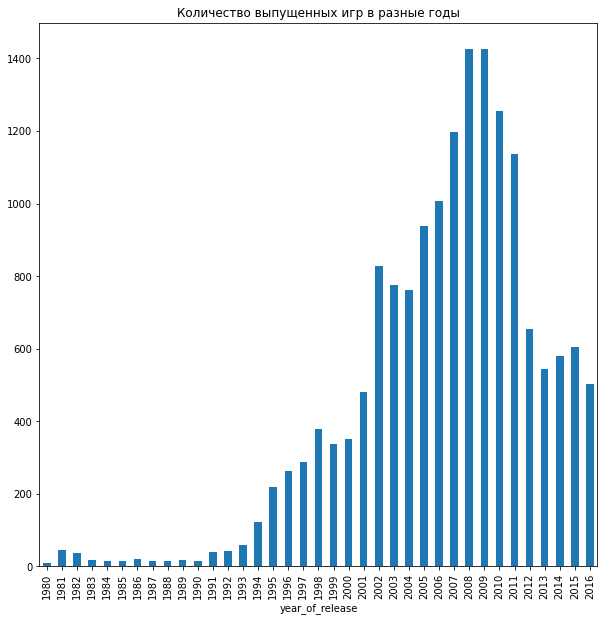

In [27]:
year_pivot = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
year_pivot.plot(kind='bar', figsize=(10,10), legend=False, title='Количество выпущенных игр в разные годы')

Думаю, до 1997 года данные не важны, так как там выпускалось мало игр

- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [28]:
top_10_platform = data.pivot_table(index='platform', values='all_sales', aggfunc='sum')
top_10_platform = list(top_10_platform.sort_values(by='all_sales', ascending=False).head(10).index)
top_10_platform

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']

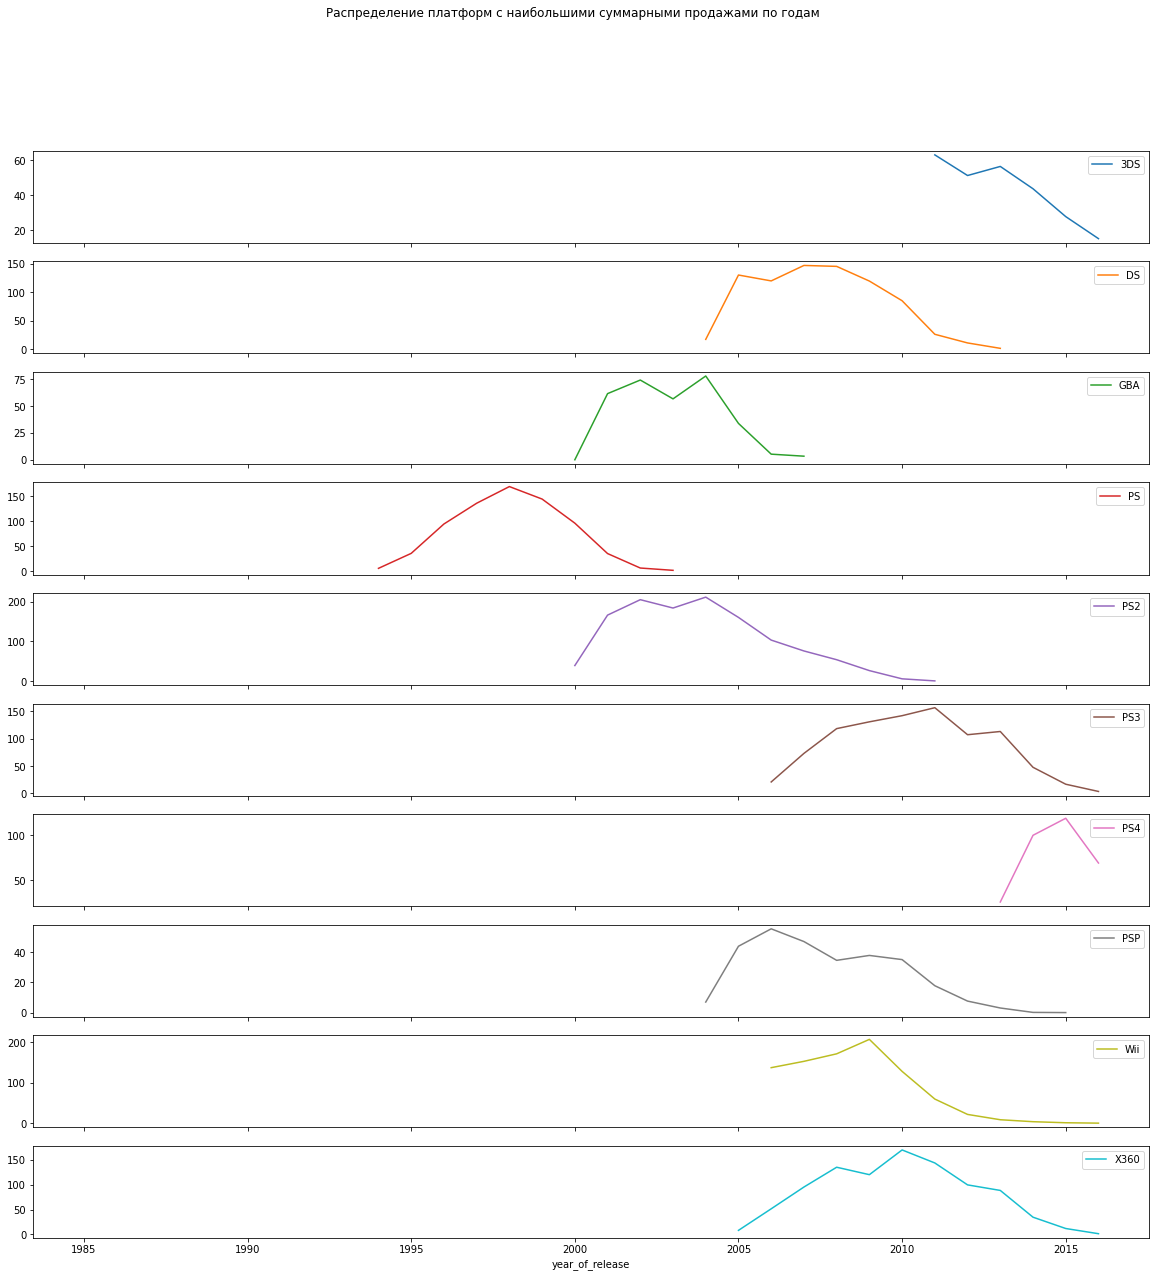

In [29]:
platform_pivot = data.query('platform in @top_10_platform').\
    pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
platform_pivot.plot(kind='line', figsize=(20, 20),\
    title='Распределение платформ с наибольшими суммарными продажами по годам', subplots=True);

Если смотреть на разницу появления и исчезновения платформ ps(1, 2, 3) и ds(ds, 3ds), то получается, что за 3-5 лет появляются новые и исчезают старые платформы

- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Думаю, актуальны период взять с 2010 года, новые платформы появились через несколько лет после этого года, а предыдущие платформы, которые еще актуальны, имели пик в +- этот год.

In [30]:
actual_data = data[data['year_of_release'] >= 2014]

- Не учитывайте в работе данные за предыдущие годы.

Этот пункт решен в предыдущем пункте

- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

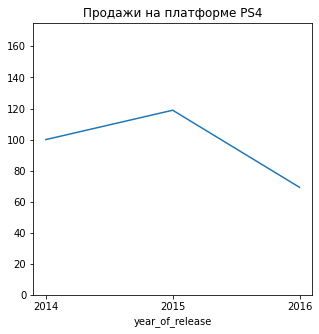

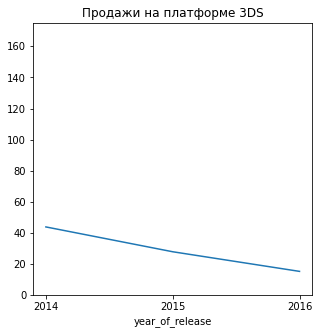

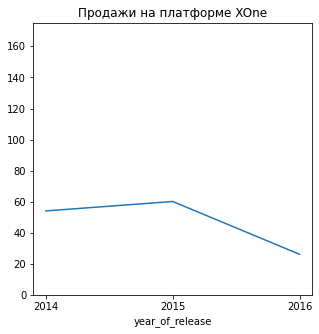

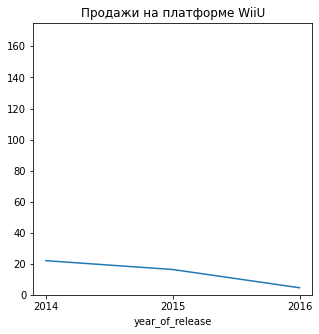

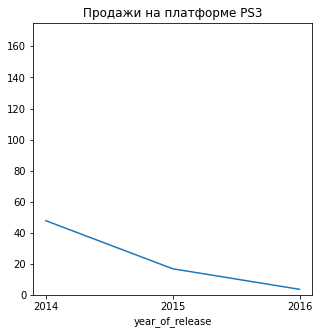

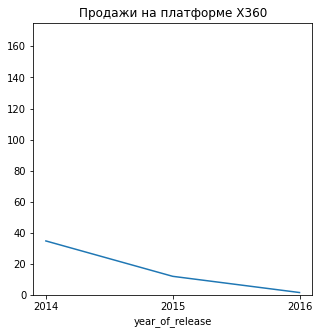

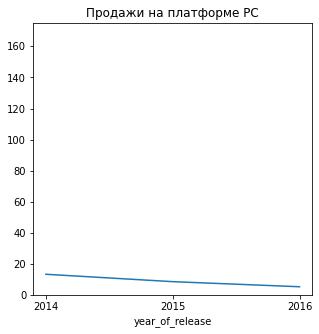

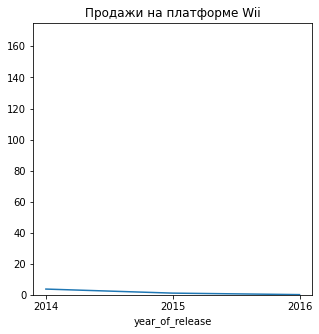

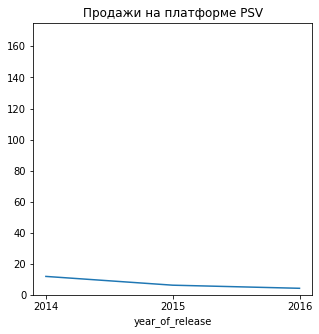

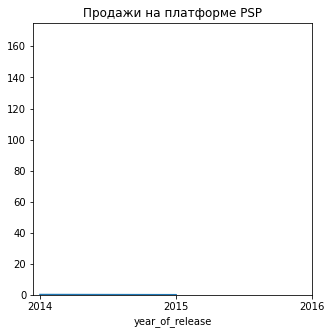

In [31]:
year_values = [2014, 2015, 2016]
platform_list = list(actual_data.platform.unique())
for platform in platform_list:
    actual_data.query('platform == @platform').pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')\
        .plot(kind='line', figsize=(5,5), title=f"Продажи на платформе {platform}", legend=False, xticks=year_values, ylim=(0, 175))
    plt.show()

1. X360 - продажи падают
2. PS3 - продажи падают
3. PS4 - продажи только начали падать, еще года 2-3 продержутся скорее всего
4. 3DS - продажи падают
5. Wii - продаж практически нет на 2016 год
6. Xone - то же, как у PS4, только у PS4 продаж больше
7. WiiU - не очень большие продажи, продаж на конец 2016 года также нет
8. PC - универсальная платформа я бы сказал, будет актуально всегда, продажи то спадают, то поднимаются
9. Psp - продажи прекратились
10. PSV - не сильно большие продажи.

Потенциально прибыльные - Xone, PS4; возможно: PC, PSV

- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

<AxesSubplot:>

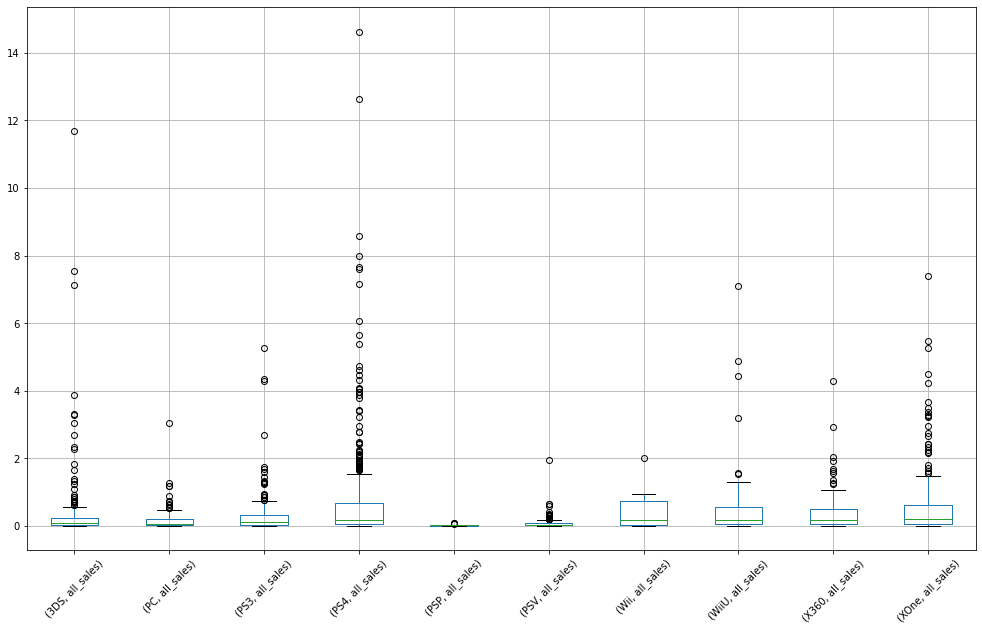

In [32]:
actual_data.groupby('platform').boxplot(figsize=(17,10), column='all_sales', subplots=False, rot=45)

В глобальных продажах на всех платформах присутствуют выбросы, и выбросы эти больше границы верхнего "уса".  
Большниство глобальных продаж не достигают значений в размере 2.5 млн.

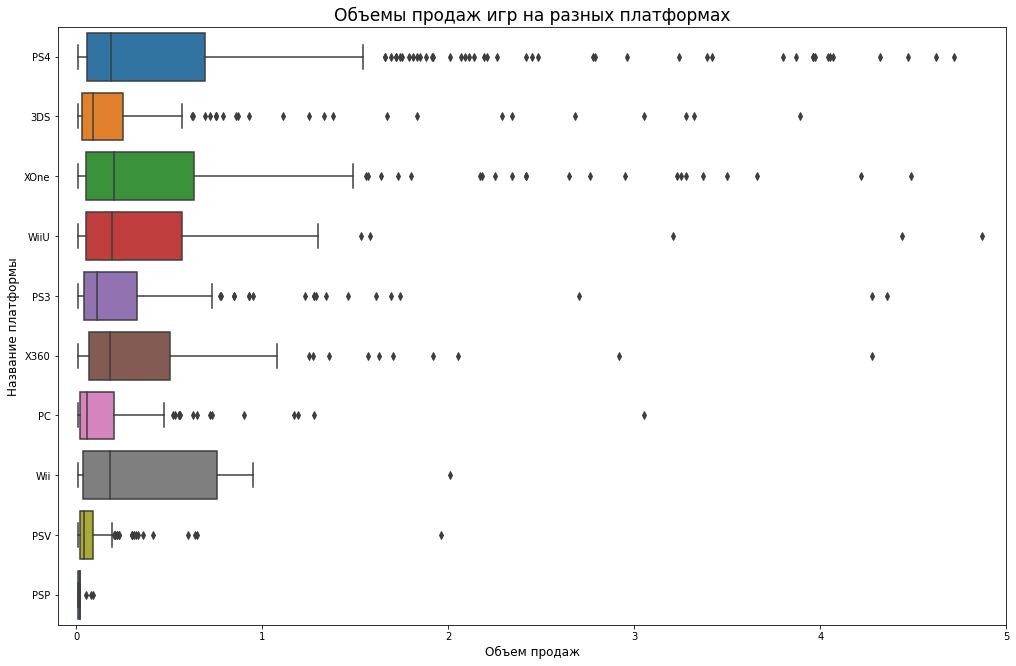

In [33]:
# код ревьюера

import seaborn as sns

plt.figure(figsize=(17, 11))
sns.boxplot(data=actual_data, y='platform', x='all_sales')
plt.xlim(-0.1, 5)

plt.title('Объемы продаж игр на разных платформах', size=17)
plt.xlabel('Объем продаж', size=12)
plt.ylabel('Название платформы', size=12)

plt.show()

- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Возьмем популярную платформу PS4, и отсеим заглушки, которые мы вводили ранее.

In [34]:
ps4_actual_data = actual_data.query("platform == 'PS4'")

In [35]:
# код ревьюера

print(actual_data.query("platform == 'PS4' and critic_score != -1 and user_score not in [-1, -2]").shape[0])
print(actual_data.query("platform == 'PS4' and critic_score != -1").shape[0])
print(actual_data.query("platform == 'PS4' and user_score not in [-1, -2]").shape[0])

234
237
242


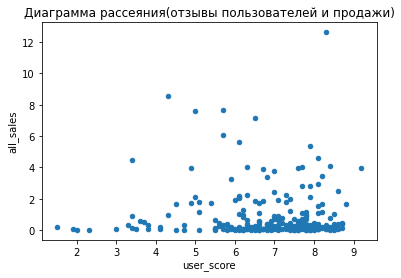

In [36]:
ps4_actual_user_data = ps4_actual_data.query("user_score not in [-1, -2]")
ps4_actual_user_data.plot(kind='scatter', x='user_score', y='all_sales', title='Диаграмма рассеяния(отзывы пользователей и продажи)');

In [37]:
ps4_actual_user_data['all_sales'].corr(ps4_actual_user_data['user_score'])

-0.040131589472697356

Корреляция между отзывами пользователей и продажами нет, на графике никакой зависимости не видно

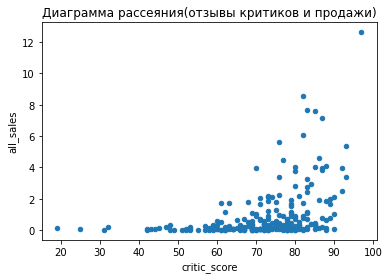

In [38]:
ps4_actual_critic_data = ps4_actual_data.query("critic_score != -1")
ps4_actual_critic_data.plot(kind='scatter', x='critic_score', y='all_sales', title='Диаграмма рассеяния(отзывы критиков и продажи)');

In [39]:
ps4_actual_critic_data['all_sales'].corr(ps4_actual_critic_data['critic_score'])

0.40266141068104083

**Вывод**:
Корреляция между отзывами критиков и продажами слабая, на графике трудно увидеть зависимостью

- Соотнесите выводы с продажами игр на других платформах.

На других платформах будет аналогичная ситуация: оценки ползователей не будут влиять на продажи, а оценки критиков будут иметь слабую корреляцию или практически не иметь ее с теми же продажами. 

Пример:  
- Платформа XOne

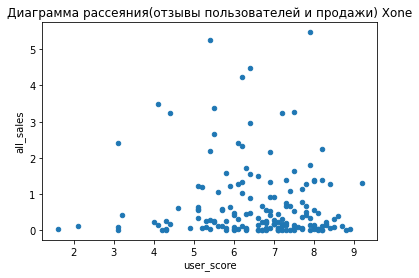

In [40]:
xone_actual_user_data = actual_data.query("platform == 'XOne' and user_score not in [-1, -2]")
xone_actual_user_data.plot(kind='scatter', x='user_score', y='all_sales', title='Диаграмма рассеяния(отзывы пользователей и продажи) Xone');

In [41]:
xone_actual_user_data['all_sales'].corr(xone_actual_user_data['user_score'])

-0.0703839280647581

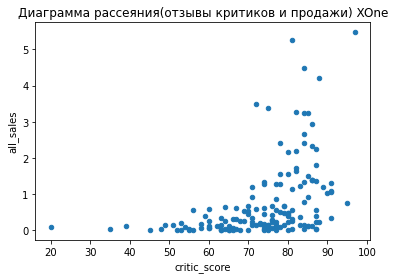

In [42]:
xone_actual_critic_data = actual_data.query("platform == 'XOne' and critic_score != -1")
xone_actual_critic_data.plot(kind='scatter', x='critic_score', y='all_sales', title='Диаграмма рассеяния(отзывы критиков и продажи) XOne');

In [43]:
xone_actual_critic_data['all_sales'].corr(xone_actual_critic_data['critic_score'])

0.42867694370333226

- Платформа PC

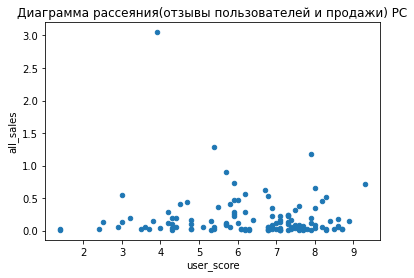

In [44]:
pc_actual_user_data = actual_data.query("platform == 'PC' and user_score not in [-1, -2]")
pc_actual_user_data.plot(kind='scatter', x='user_score', y='all_sales', title='Диаграмма рассеяния(отзывы пользователей и продажи) PC');

In [45]:
pc_actual_user_data['all_sales'].corr(pc_actual_user_data['user_score'])

-0.07159665703472452

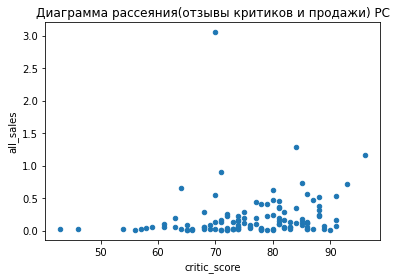

In [46]:
pc_actual_critic_data = actual_data.query("platform == 'PC' and critic_score != -1")
pc_actual_critic_data.plot(kind='scatter', x='critic_score', y='all_sales', title='Диаграмма рассеяния(отзывы критиков и продажи) PC');

In [47]:
pc_actual_critic_data['all_sales'].corr(pc_actual_critic_data['critic_score'])

0.17463413769350036

- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

<AxesSubplot:title={'center':'Продажи на одну игру в жанре'}, xlabel='Жанры'>

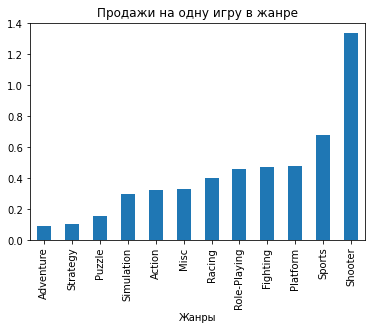

In [48]:
genre_grouped = actual_data.groupby('genre').agg(count_games=('name', 'count'), all_sales=('all_sales', 'sum'))
#находим количество продаж на одну игру в жанре
genre_grouped['sale_to_game'] = genre_grouped['all_sales'] /  genre_grouped['count_games']
genre_grouped['sale_to_game'].sort_values().plot(kind='bar', title='Продажи на одну игру в жанре', xlabel='Жанры')

Шутеры - жанр с высокими продажами  
Приключения - жанр с низкими продажами

## Составьте портрет пользователя каждого региона

In [49]:
columns = {'NA': 'na_sales', 'EU': 'eu_sales', 'JP': 'jp_sales'}

- Самые популярные платформы (топ-5)

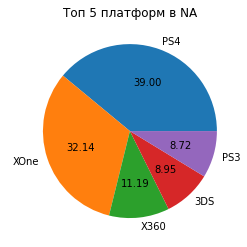

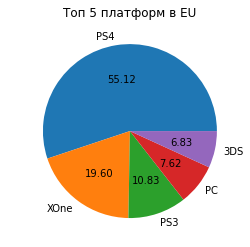

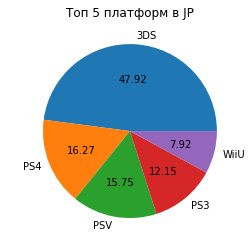

In [50]:
def autopct(pct):
    return ('%.2f' % pct)

for region, column in columns.items():
    actual_data.groupby('platform')[column].sum().sort_values(ascending=False).head(5).\
    plot(kind='pie', title=f'Топ 5 платформ в {region}', ylabel=' ', autopct=autopct)
    plt.show()

**NA**:  

Приставки серии PS имеют первое место по популярности в Северной Америке, скорее всего из-за качества игр и эксклюзивов на данную платформу.    
Microsoft имеет расположение в Америке, и скорее всего из-за этого приставки серии Xbox расположились по популярности на втором месте.

**EU**:  

Консоли серии PS - явные лидеры в этом регионе. Возможной причиной,как и в Северной Америке, может быть отличные эксклюзивные игры.  
Дальше идут XOne, PC, WII

**JP**:  

Ну, японцы вроде любят в покемончиков🙂 и тому подобное поиграть, а DS легкая консоль, вот и покупают его)  
DS была выпущена в Канаде, США и Японии. Но видимо, в США и Канаде не очень прижилась.  
Консоли серии PS - комания SONY расположена в Японии, скорее всего из-за этого у него тоже есть популярность в Японии, ну и опять же, отличное качество игр и эксклюзивные игры.

- Самые популярные жанры (топ-5).

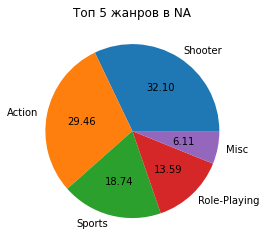

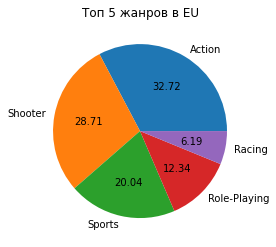

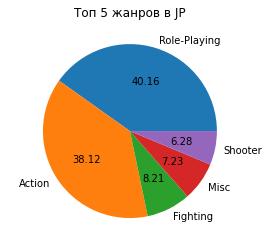

In [51]:
for region, column in columns.items():
    actual_data.groupby('genre')[column].sum().sort_values(ascending=False).head(5).\
    plot(kind='pie', title=f'Топ 5 жанров в {region}', ylabel=' ', autopct=autopct)
    plt.show()

**NA** и **EU** практически не отличаются, и там и там лидируют игры жанра Action и Shooter. Отличие лишь в последних местах, но и то это отличием назвать нельзя, так как misc это прочие жанры.
Возможно большинство игр на консоли серии ps и xbox имеют формат action, shooter и тд, поэтому эти жанры популярны

**JP**:
В силу любви к персонажам из покемончиков и тд, Японцы наверно предпочитают role play игры. Популярность приставки ps и от части ds возможно повлияла на популярность жанра action и shooter.


- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

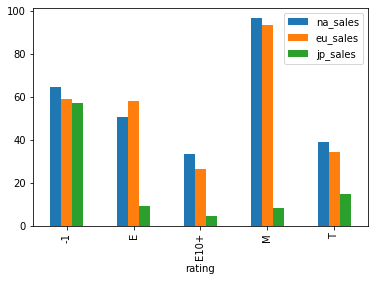

In [52]:
actual_data.groupby('rating').agg(
    na_sales=('na_sales', 'sum'),
    eu_sales=('eu_sales', 'sum'),
    jp_sales=('jp_sales', 'sum')
        ).plot(kind='bar');

Наврено влияют, рассмотрим **северную америку** и **европу**:  

Рейтинг **"M"** имеет больше продаж, наверно потому, что взрослые(mature) имеет куда больше денег, чем дети.  
На втором месте расположился по продажам рейтинг, который был пропущен в данных.  
Далее по продажам идет рейтинг **"E"**(everyone).  
Следом идут рейтинги **T** и **E10+**     

А вот в **Японии** ситуация отличается:  

Особо то и не заметно, что рейтинг влияет на продажи. Рейтинги **E, E10+, M** держутся на примерно одном уровне.  
Чуть выше их уровня расположился рейтинг **T**.  
А самое большое количество продаж имеет рейтинг, который был пропущен в данных.  


## Проверьте гипотезы

In [53]:
alpha = 0.05

In [54]:
actual_data = actual_data.query('user_score not in [-1, -2]')

In [55]:
actual_data.platform.unique()

array(['PS4', 'WiiU', 'XOne', 'PS3', 'X360', '3DS', 'PC', 'Wii', 'PSV'],
      dtype=object)

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

H0: Средний пользовательский рейтинг платформ Xbox One = Средний пользовательский рейтинг платформ PC  
H1: Средний пользовательский рейтинг платформ Xbox One ≠ Средний пользовательский рейтинг платформ PC  

In [56]:
xone_actual_data = actual_data[actual_data['platform'] == 'XOne']['user_score']
pc_actual_data = actual_data[actual_data['platform'] == 'PC']['user_score']

results = st.ttest_ind(xone_actual_data, pc_actual_data, equal_var = False)

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

0.11601398086668832
Не получилось отвергнуть нулевую гипотезу 


**Вывод**:<br>    
С уровнем значимости в 5 процентов мы принимаем первую гипотезу, то есть средний пользовательский рейтинг платформ Xbox One одинаков со средним пользовательским рейтингом платформ PC

- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H0: Средний пользовательский рейтинг жанра Action = Средний пользовательский рейтинг жанра Sports  
H1: Средний пользовательский рейтинг жанра Action ≠ Средний пользовательский рейтинг жанра Sports

In [57]:
action_actual_data = actual_data[actual_data['genre'] == 'Action']['user_score']
sports_actual_data = actual_data[actual_data['genre'] == 'Sports']['user_score']

results = st.ttest_ind(action_actual_data, sports_actual_data, equal_var = False)

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

1.1825550382644557e-14
Отвергаем нулевую гипотезу


**Вывод**:<br>    
С уровнем значимости в 5 процентов мы отвергаем нулевую гипотезу, поэтому средний пользовательский рейтинг жанра Action отличается от среднего пользовательского рейтинга жанра Sports

- Как вы сформулировали нулевую и альтернативную гипотезы?

Сравниваем между собой генеральные средние двух выборок. В первом случае они должны быть равны, а во втором нет. И там и там проверяем двухсторонние гипотезы, чтобы не усложнять)

- Какой критерий применили для проверки гипотез и почему?

T-критерий Стьюдента. Если значений в выборке много, то распределение стьюдента близко к нормальному, поэтому мы взяли этот критерий.

## Вывод

### Данные

Рекомендации: 
- Следует уменьшить кол-во пропусков в данных, максимальная их доля была **51** процентов.
- Присутствовали выбросы(значения не в пределах нормы) во многих столбцах, надо исправить 

Предобработка:  
- Заглушки на **user_score**(-1 для nan, -2 для tbd), **critic_score**(-1 для nan), **rating**("-1" для nan), в других столбцах были удалены, если были  
- Столбцы изменены на правильные название и в некоторых изменены типы
- Добавлен столбец all_sales для всех продаж по всем регионам  

### Исследования

- **потенциально прибыльные платформы**:

Рассмотрев графики, можно сказать, что новые серии консолей ps и xbox, а именно PS4 и Xbox One, являются потенциально прибыльными платформами. Продажи по этим платформам еще идут в хорошем темпе. Лучший из них PS4. Также можно обратить внимание и на платформу PC

- **влияние отзывов пользователей и критиков**:

Отзывы пользователей совсем не влияют на продажи, корреляция **отсутствует**  
Отзывы критиков влияют не так сильно, корреляция **40.3 %** для платформы **PS4**, для других может быть и меньше

- **Жанры**:

Шутеры, спортивные, платформеры, fighting, role play, гоночные игры - имеют хорошие продажи

- **Регионы**  
    - **EU**: Консоли серии **PS** - явные лидеры в этом регионе. Лидируют игры жанра **Action, Shooter, Sports**
    - **NA**: Консоли серии **PS** более популярны там. Лидируют игры жанра **Shooter, Action, Sports**
    - **JP**: Консоли серии **DS** более популярны там, но серия **PS** тоже идет наравне в с ним. Лидируют жанры **Role Play, Action, Fighting**
    
    
- **Гипотезы**:

Подтвердилась гипотеза, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
И также подтвердилось, что средние пользовательские рейтинги жанров Action и Sports разные.